In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
df = pd.read_csv('https://s3.amazonaws.com/datarobot_public_datasets/DR_Demo_Fire_Ins_Loss_only.csv')
# df.head()

In [4]:
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor

features = df.loc[:, ~df.columns.isin(['loss'])]
target = df.loss

training_features, testing_features, training_target, testing_target = \
            train_test_split(features, target, random_state=None)

In [7]:
data_types = { # 'loss': 'Numeric',
'crime_burglary': 'Numeric',
'crime_risk': 'Numeric',
'ISO_desc': 'Text',
'Norm_fire_risk': 'Numeric',
'crime_arson': 'Numeric',
'ISO': 'Numeric',
'Weather_risk': 'Numeric',
'Geographical_risk': 'Numeric',
'Premium_remain': 'Numeric',
'Renewal_Type': 'Categorical',
'Commercial': 'Categorical',
'crime_property_type': 'Numeric',
'Renewal_class': 'Categorical',
'crime_neighbour_watch': 'Numeric',
'Previous_claims': 'Numeric',
'Exposure': 'Numeric',
'crime_area': 'Numeric',
'ISO_cat': 'Categorical',
'Norm_monthly_rent': 'Numeric',
'No_claim_Years': 'Numeric',
'crime_residents': 'Numeric',
'Norm_area_m': 'Numeric',
'Rating_Class': 'Categorical',
'Property_size': 'Numeric',
'Residents': 'Numeric',
'crime_community': 'Numeric',
'Loan_mortgage': 'Numeric',
'Premium_renew': 'Numeric',
'Sub_Renewal_Class': 'Categorical',
'Sub_Rating_Class': 'Categorical'}

numeric_features = [ k for k,v in data_types.items() if v == 'Numeric']
text_features = [ k for k,v in data_types.items() if v == 'Text']
categorical_features = [ k for k,v in data_types.items() if v == 'Categorical']

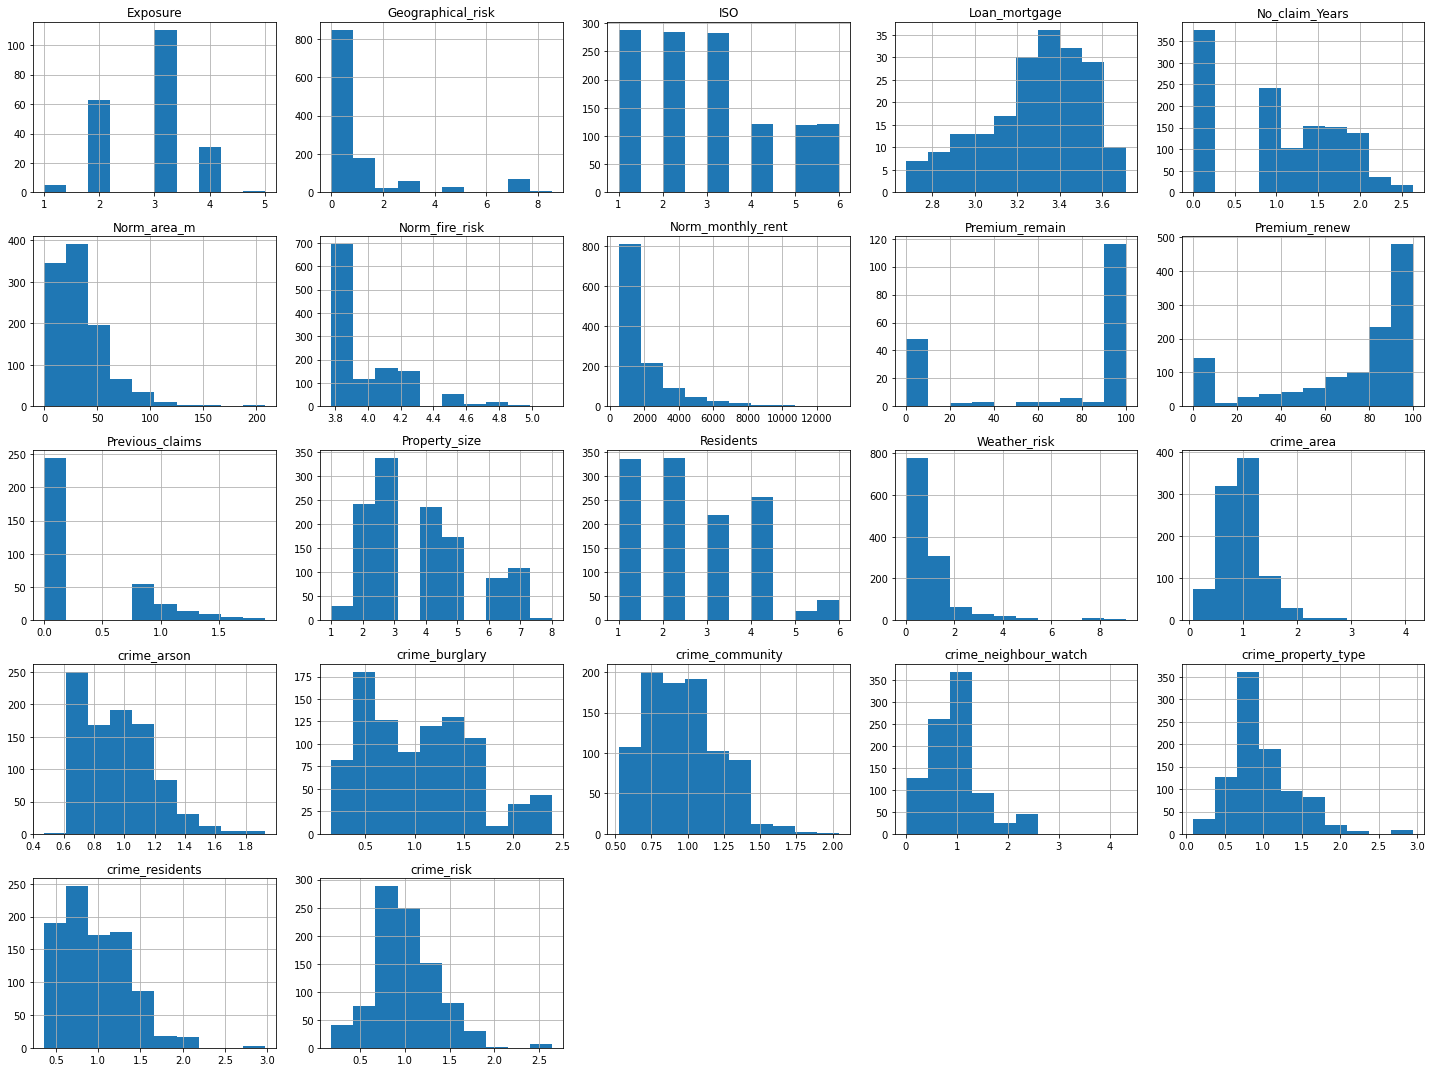

In [8]:
sorted_columns = sorted(df[numeric_features].columns)
df[sorted_columns].hist(figsize=(20,15))
plt.tight_layout()
plt.show()

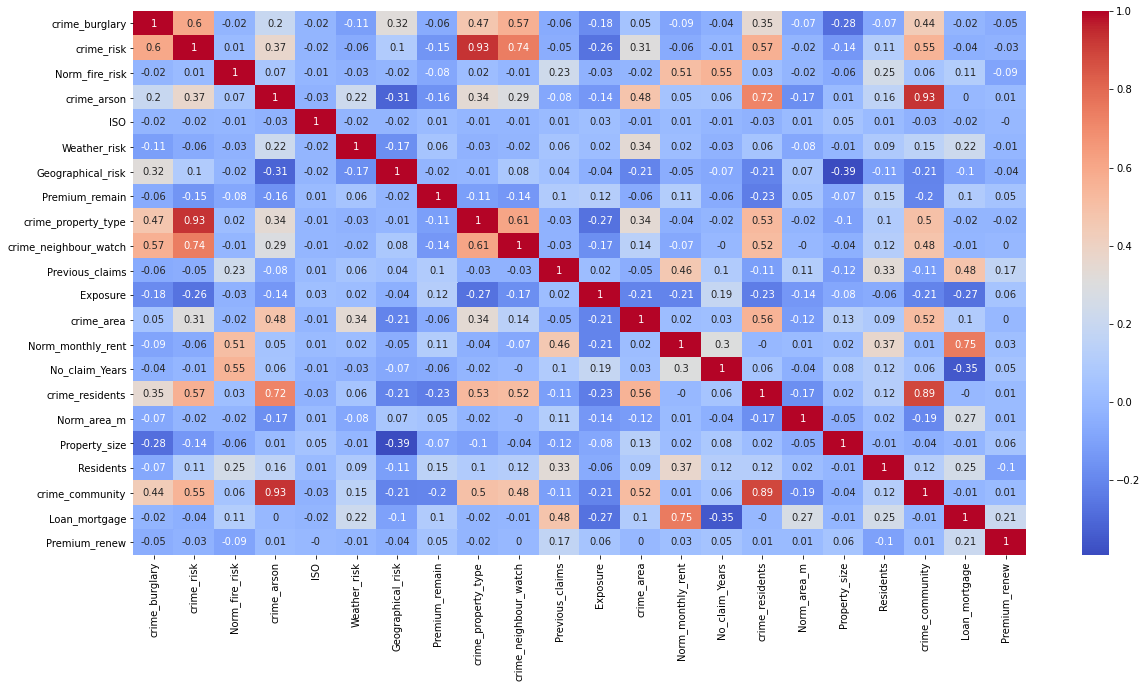

In [88]:
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(round(df[numeric_features].corr(), 2), annot=True, cmap='coolwarm', ax=ax)

In [90]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.pipeline import FeatureUnion

numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

text_pipeline = Pipeline(steps=[
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer())
])

feature_extractors = [('poly', PolynomialFeatures()), ('pca', PCA())]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_features),
        ('cat', categorical_pipeline, categorical_features),
        # ('text', text_pipeline, text_features),
    ])

est = Pipeline(steps=[('preprocessor', preprocessor),
                      ('fu', FeatureUnion(feature_extractors)),
                      ('rf', RandomForestRegressor(n_estimators=10, criterion='mse', n_jobs=-1))
                      ])
est.fit(training_features, training_target)
print("model score (mae) - RF: {:.4f}".format(mean_absolute_error(testing_target, est.predict(testing_features))))

model score (mae) - RF: 0.0390


In [93]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures

est = Pipeline(steps=[('preprocessor', preprocessor),
                      ('rf', RandomForestRegressor())
                      ])

gs = GridSearchCV(estimator=est, param_grid={'rf__criterion': ['mse', 'mae'],
                                             'rf__n_estimators': range(5, 30, 5),
                                             'rf__max_depth': [4, 5, 6, 7],
                                             'rf__n_jobs': [-1]}, 
                  scoring='neg_mean_absolute_error', cv=3, refit=True, verbose=10)

gs.fit(training_features, training_target)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV] rf__criterion=mse, rf__max_depth=4, rf__n_estimators=5, rf__n_jobs=-1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  rf__criterion=mse, rf__max_depth=4, rf__n_estimators=5, rf__n_jobs=-1, score=-0.036, total=   1.1s
[CV] rf__criterion=mse, rf__max_depth=4, rf__n_estimators=5, rf__n_jobs=-1 
[CV]  rf__criterion=mse, rf__max_depth=4, rf__n_estimators=5, rf__n_jobs=-1, score=-0.036, total=   0.2s
[CV] rf__criterion=mse, rf__max_depth=4, rf__n_estimators=5, rf__n_jobs=-1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV]  rf__criterion=mse, rf__max_depth=4, rf__n_estimators=5, rf__n_jobs=-1, score=-0.034, total=   0.2s
[CV] rf__criterion=mse, rf__max_depth=4, rf__n_estimators=10, rf__n_jobs=-1 
[CV]  rf__criterion=mse, rf__max_depth=4, rf__n_estimators=10, rf__n_jobs=-1, score=-0.036, total=   0.2s
[CV] rf__criterion=mse, rf__max_depth=4, rf__n_estimators=10, rf__n_jobs=-1 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.6s remaining:    0.0s


[CV]  rf__criterion=mse, rf__max_depth=4, rf__n_estimators=10, rf__n_jobs=-1, score=-0.035, total=   0.2s
[CV] rf__criterion=mse, rf__max_depth=4, rf__n_estimators=10, rf__n_jobs=-1 
[CV]  rf__criterion=mse, rf__max_depth=4, rf__n_estimators=10, rf__n_jobs=-1, score=-0.034, total=   0.2s
[CV] rf__criterion=mse, rf__max_depth=4, rf__n_estimators=15, rf__n_jobs=-1 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.9s remaining:    0.0s


[CV]  rf__criterion=mse, rf__max_depth=4, rf__n_estimators=15, rf__n_jobs=-1, score=-0.036, total=   0.2s
[CV] rf__criterion=mse, rf__max_depth=4, rf__n_estimators=15, rf__n_jobs=-1 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    2.2s remaining:    0.0s


[CV]  rf__criterion=mse, rf__max_depth=4, rf__n_estimators=15, rf__n_jobs=-1, score=-0.035, total=   0.2s
[CV] rf__criterion=mse, rf__max_depth=4, rf__n_estimators=15, rf__n_jobs=-1 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.4s remaining:    0.0s


[CV]  rf__criterion=mse, rf__max_depth=4, rf__n_estimators=15, rf__n_jobs=-1, score=-0.034, total=   0.2s
[CV] rf__criterion=mse, rf__max_depth=4, rf__n_estimators=20, rf__n_jobs=-1 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.6s remaining:    0.0s


[CV]  rf__criterion=mse, rf__max_depth=4, rf__n_estimators=20, rf__n_jobs=-1, score=-0.037, total=   0.2s
[CV] rf__criterion=mse, rf__max_depth=4, rf__n_estimators=20, rf__n_jobs=-1 
[CV]  rf__criterion=mse, rf__max_depth=4, rf__n_estimators=20, rf__n_jobs=-1, score=-0.035, total=   0.2s
[CV] rf__criterion=mse, rf__max_depth=4, rf__n_estimators=20, rf__n_jobs=-1 
[CV]  rf__criterion=mse, rf__max_depth=4, rf__n_estimators=20, rf__n_jobs=-1, score=-0.034, total=   0.2s
[CV] rf__criterion=mse, rf__max_depth=4, rf__n_estimators=25, rf__n_jobs=-1 
[CV]  rf__criterion=mse, rf__max_depth=4, rf__n_estimators=25, rf__n_jobs=-1, score=-0.036, total=   0.2s
[CV] rf__criterion=mse, rf__max_depth=4, rf__n_estimators=25, rf__n_jobs=-1 
[CV]  rf__criterion=mse, rf__max_depth=4, rf__n_estimators=25, rf__n_jobs=-1, score=-0.035, total=   0.2s
[CV] rf__criterion=mse, rf__max_depth=4, rf__n_estimators=25, rf__n_jobs=-1 
[CV]  rf__criterion=mse, rf__max_depth=4, rf__n_estimators=25, rf__n_jobs=-1, score=-

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   56.4s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                    

In [94]:
print("model score: {:.4f}".format(mean_absolute_error(testing_target, gs.predict(testing_features))),
      f"\nbest model's parameters: { gs.best_params_}")

model score: 0.0389 
best model's parameters: {'rf__criterion': 'mae', 'rf__max_depth': 6, 'rf__n_estimators': 20, 'rf__n_jobs': -1}


In [95]:
from skopt import BayesSearchCV
from sklearn.svm import SVR
from skopt.space import Real, Categorical, Integer

opt = BayesSearchCV(
    SVR(),
    {
        'C': Real(1e-6, 1e+6, prior='log-uniform'),  
        'gamma': Real(1e-6, 1e+1, prior='log-uniform'),
        'degree': Integer(1, 8),  # integer valued parameter
        'kernel': Categorical(['linear', 'poly', 'rbf']), 
    },
    optimizer_kwargs={'base_estimator': 'RF'},
    n_iter=40,
    cv=3,
    random_state=0
)

opt.fit(training_features[numeric_features].fillna(0).astype(int), training_target)

print(f"val. score: {opt.best_score_}" )
print("test score: {:.4f}".format(opt.score(testing_features[numeric_features].fillna(0).astype(int), testing_target)))

val. score: -0.2620798436098173
test score: -0.1798


In [96]:
print("model score (mae): {:.4f}".format(mean_absolute_error(testing_target, opt.predict(testing_features[numeric_features].fillna(0).astype(int)))))

model score (mae): 0.0490
